# Alternative Energies in Argentina

This project aims to take a look at Argentina's renewable energy production focused mainly on how they distribute along the country and the reasons behind its locations. 

To do so, I use Kaggle's dataset linked below. Since the idea of this notebook is to put my data science skills learned here [Data Analysis with Python: Zero to Pandas](zerotopandas.com) to a test, I consider this dataset to be enough although is not a fully trustable source

I'll use basic visualization tools learned in the course and some geospatial utilities along the way

## Installing dependencies
Let's install the necessary packages. In case that this notebook is running from Jovian on Binder, only opendatasets and geopandas should be necessary

In [1]:
!pip install pandas numpy seaborn matplotlib opendatasets geopandas jovian --upgrade --quiet

## Downloading the Dataset

We use Kaggle's following Dataset:
https://www.kaggle.com/ccollado7/alternative-energies-argentina

Let's begin by downloading the data, and listing the files within the dataset.

**Note** if no Kaggle's API keys are present, the dataset can be directly added to ```/alternative-energies-argentina``` (must create that directory within this notebook's directory first). That file can be downloaded from Github repository referenced at the end of this notebook

In [2]:
import opendatasets as od

In [3]:
od.download('https://www.kaggle.com/ccollado7/alternative-energies-argentina')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: 

 simonaulet


Your Kaggle Key: 

 ································


100%|██████████| 32.2k/32.2k [00:00<00:00, 1.26MB/s]

The dataset has been downloaded and extracted.

In [4]:
import os
data_dir = './alternative-energies-argentina_files'

In [5]:
os.replace('alternative-energies-argentina', data_dir)
os.listdir(data_dir)

['energias-alternativas.csv']

In [6]:
from urllib.request import urlretrieve

## Data Preparation and Cleaning

We import a table with the renewable energy generation info

In [7]:
import pandas as pd

In [8]:
energies_raw_df = pd.read_csv(data_dir+'/energias-alternativas.csv', encoding='latin1')#encoding specification needed for language reasons
energies_raw_df.sample(10)

,sector_id,sector_nombre,variable_id,actividad_producto_nombre,indicador,unidad_de_medida,fuente,frecuencia_nombre,cobertura_nombre,alcance_tipo,alcance_id,alcance_nombre,indice_tiempo,valor
4153,25,Energías alternativas,448,Energía pah,Potencia instalada,MW,CAMMESA,Mensual,Nacional,PROVINCIA,50,MENDOZA,2016-07-01,73.820
2487,25,Energías alternativas,446,Energía nuclear,Potencia instalada,MW,CAMMESA,Mensual,Nacional,PROVINCIA,14,CORDOBA,2013-09-01,648.000
2850,25,Energías alternativas,447,Energía pah,Generación,MWh,CAMMESA,Mensual,Nacional,PROVINCIA,38,JUJUY,2013-12-01,7385.445
3410,25,Energías alternativas,447,Energía pah,Generación,MWh,CAMMESA,Mensual,Nacional,PROVINCIA,70,SAN JUAN,2020-08-01,13891.589
5269,25,Energías alternativas,450,Energía solar,Potencia instalada,MW,CAMMESA,Mensual,Nacional,PROVINCIA,70,SAN JUAN,2020-07-01,199.110
773,25,Energías alternativas,442,Energía biomasa,Generación,MWh,CAMMESA,Mensual,Nacional,PROVINCIA,54,MISIONES,2015-06-01,5263.922
2315,25,Energías alternativas,445,Energía nuclear,Generación,MWh,CAMMESA,Mensual,Nacional,PROVINCIA,14,CORDOBA,2017-05-01,0.000
4836,25,Energías alternativas,449,Energía solar,Generación,MWh,CAMMESA,Mensual,Nacional,PROVINCIA,50,MENDOZA,2019-06-01,0.000
287,25,Energías alternativas,441,Energía biogás,Potencia instalada,MW,CAMMESA,Mensual,Nacional,PROVINCIA,6,BUENOS AIRES,2012-12-01,16.600
4947,25,Energías alternativas,449,Energía solar,Generación,MWh,CAMMESA,Mensual,Nacional,PROVINCIA,70,SAN JUAN,2016-09-01,1339.283


We inspect the 'actividad_producto_nombre' column to see what is it about and then check for unnecessary columns by counting unique values for each one

In [9]:
energies_raw_df.actividad_producto_nombre.unique()#check the energy sources

array(['Energía biogás', 'Energía biomasa', 'Energía eólica',
       'Energía nuclear', 'Energía pah', 'Energía solar'], dtype=object)

In [10]:
#Check to find innecesary columns
for column in energies_raw_df.columns:
    print('Column {} has {} unique values'.format(column,energies_raw_df[column].unique().__len__()))

Column sector_id has 1 unique values
Column sector_nombre has 1 unique values
Column variable_id has 11 unique values
Column actividad_producto_nombre has 6 unique values
Column indicador has 2 unique values
Column unidad_de_medida has 2 unique values
Column fuente has 1 unique values
Column frecuencia_nombre has 1 unique values
Column cobertura_nombre has 1 unique values
Column alcance_tipo has 1 unique values
Column alcance_id has 19 unique values
Column alcance_nombre has 19 unique values
Column indice_tiempo has 120 unique values
Column valor has 2792 unique values


### Columns to be used:
Based on previous info, we can safely remove a lot of columns. We will keep the following ones
- **actividad_producto_nombre** Is the source for the energy.
    - Biogas
    - Biomass
    - Wind
    - Nuclear
    - "pah" _pequeños aprovechamientos hidricos_ means small hydro
    - Solar energy
- **indicador** Means either the row corresponds to available power or energy that has been generated.
- **alcance_nombre** Name of the province
- **indice_tiempo** Time-lapse of the row
- **valor** Value in MW if it is installed power and MWh if it is energy produced

Let's create a new Data Frame with only the columns that we are interested in to start working on it

In [11]:
energies_df = energies_raw_df[['actividad_producto_nombre', 'indicador', 'alcance_nombre', 'indice_tiempo', 'valor']].copy()
energies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5311 entries, 0 to 5310
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   actividad_producto_nombre  5311 non-null   object 
 1   indicador                  5311 non-null   object 
 2   alcance_nombre             5311 non-null   object 
 3   indice_tiempo              5311 non-null   object 
 4   valor                      5311 non-null   float64
dtypes: float64(1), object(4)
memory usage: 207.6+ KB


Column `info` is a date type. We set it to be interpreted as such

In [12]:
energies_df.indice_tiempo = pd.to_datetime(energies_df.indice_tiempo)

This study is in English. All values must be translated, except for the Province name. First, we translate column names and then contents

In [13]:
#Column names
column_rename = {'actividad_producto_nombre' : 'energy_source',
                            'indicador' : 'indicator',
                            'alcance_nombre' : 'province',
                            'indice_tiempo' : 'date',
                            'valor' : 'value'}
energies_df.rename(columns=column_rename, inplace=True)

In [14]:
#Contents
energies_df.replace({'Energía biogás': 'Biogas',
                    'Energía biomasa': 'Biomass',
                    'Energía eólica': 'Wind',
                    'Energía nuclear': 'Nuclear',
                    'Energía pah': 'Small_hydro',
                    'Energía solar': 'Solar',
                    'Generación': 'Generated_energy',
                    'Potencia instalada': 'Installed_power'},
                   inplace=True)

Let's have a look at our new data frame

In [15]:
energies_df.sample(10)

,energy_source,indicator,province,date,value
3757,Small_hydro,Generated_energy,TUCUMAN,2019-07-01,6359.265
1950,Wind,Installed_power,LA RIOJA,2016-07-01,50.400
1255,Wind,Generated_energy,CHUBUT,2011-08-01,6.421
710,Biomass,Generated_energy,CORRIENTES,2020-03-01,0.000
1953,Wind,Installed_power,LA RIOJA,2016-10-01,50.400
749,Biomass,Generated_energy,MISIONES,2013-06-01,3635.872
817,Biomass,Generated_energy,MISIONES,2019-02-01,7591.438
3060,Small_hydro,Generated_energy,RIO NEGRO,2011-06-01,0.000
4646,Small_hydro,Installed_power,TUCUMAN,2012-08-01,51.600
1274,Wind,Generated_energy,CHUBUT,2013-03-01,26869.868


It all looks good. Now some info about the data in general

In [16]:
energies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5311 entries, 0 to 5310
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   energy_source  5311 non-null   object        
 1   indicator      5311 non-null   object        
 2   province       5311 non-null   object        
 3   date           5311 non-null   datetime64[ns]
 4   value          5311 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 207.6+ KB


No NaN values in the data frame. Now the descriptive info about the `values` column; is the only float number

In [17]:
energies_df.describe()

,value
count,5311.000000
mean,20086.474353
std,75980.809927
min,0.000000
25%,19.500000
50%,349.850000
75%,9156.317500
max,752501.256000


It is hard to get something out of this since we don't know much about the data itself. There seems to be a huge standard deviation which is logical since this dataset is focused on renewable energy sources, independent of their size

Finally, the time-lapse of the data

In [18]:
print('Data starts from {}-{} and ends in {}-{}'.format(energies_df.date.min().month, energies_df.date.min().year, energies_df.date.max().month, energies_df.date.max().year))

Data starts from 1-2011 and ends in 12-2020


### Map cleaning up and merging
We will use a geojson map which we retrieve from here https://nicoarzani.carto.com/tables/provincias_argentina/public

Let's import our map and clean it up

In [19]:
urlretrieve('https://nicoarzani.carto.com/api/v2/sql?filename=provincias_argentina&q=select+*+from+public.provincias_argentina&format=geojson', data_dir+'/provincias_argentina.geojson')

('./alternative-energies-argentina_files/provincias_argentina.geojson',
 <http.client.HTTPMessage at 0x7fbe9cd5bfd0>)

In order to work with geospatial data, we use Geopandas, a library for general geospatial interpretation/manipulation

In [20]:
import geopandas as gpd

In [21]:
arg_map_raw = gpd.read_file(data_dir+'/provincias_argentina.geojson')

In [22]:
arg_map_raw.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   cartodb_id   26 non-null     int64   
 1   draworder    0 non-null      object  
 2   visibility   26 non-null     int64   
 3   extrude      26 non-null     int64   
 4   tessellate   26 non-null     int64   
 5   icon         0 non-null      object  
 6   description  26 non-null     object  
 7   name         26 non-null     object  
 8   timestamp    0 non-null      object  
 9   geometry     26 non-null     geometry
dtypes: geometry(1), int64(4), object(5)
memory usage: 2.2+ KB


In [23]:
arg_map_raw.sample(12)

,cartodb_id,draworder,visibility,extrude,tessellate,icon,description,name,timestamp,geometry
14,13,None,-1,-1,-1,None,Mendoza,Provincia de Mendoza (Argentina),None,"MULTIPOLYGON (((-70.12024 -32.57922, -70.16968..."
10,4,None,-1,-1,-1,None,Chubut,Provincia de Chubut (Argentina),None,"MULTIPOLYGON (((-64.90711 -42.16466, -64.95667..."
13,12,None,-1,-1,-1,None,La Rioja,Provincia de La Rioja (Argentina),None,"MULTIPOLYGON (((-65.73716 -29.31352, -65.75084..."
8,2,None,-1,-1,-1,None,Catamarca,Provincia de Catamaraca (Argentina),None,"MULTIPOLYGON (((-66.16377 -26.57554, -66.14319..."
12,10,None,-1,-1,-1,None,Jujuy,Provincia de Jujuy (Argentina),None,"MULTIPOLYGON (((-64.33717 -24.42421, -64.27825..."
11,9,None,-1,-1,-1,None,Formosa,Provincia de Formosa (Argentina),None,"MULTIPOLYGON (((-62.00633 -22.98926, -62.00271..."
6,1,None,-1,-1,-1,None,Buenos Aires,Provincia de Buenos Aires (Argentina),None,"MULTIPOLYGON (((-61.72119 -34.37064, -63.39661..."
7,6,None,-1,-1,-1,None,Corrientes,Provincia de Corrientes (Argentina),None,"MULTIPOLYGON (((-57.64390 -30.34800, -57.63771..."
17,17,None,-1,-1,-1,None,Salta,Provincia de Salta (Argentina),None,"MULTIPOLYGON (((-67.94220 -25.22978, -67.88246..."
5,5,None,-1,-1,-1,None,Corrientes,Provincia de Corrientes (Argentina),None,"MULTIPOLYGON (((-57.64390 -30.34800, -57.63771..."


Some provinces are not in the energies_df dataset. That can be because there is no renewable energy source. Also, some provinces are duplicated.
We create a copy in which we keep only province's names and geometry data

In [24]:
arg_map = arg_map_raw[['description', 'geometry']].copy()

In [25]:
arg_map['province'] = arg_map.description
arg_map.drop(columns='description', inplace=True)
arg_map.province=arg_map.province.str.upper()
arg_map.drop_duplicates(subset=['province'], inplace=True)
arg_map.set_index('province', inplace=True)

In [26]:
arg_map.rename(index={'CÓRDOBA': 'CORDOBA', 'NEUQUÉN': 'NEUQUEN', 'TUCUMÁN': 'TUCUMAN', 'ENTRE RÍOS': 'ENTRE RIOS', 'RÍO NEGRO': 'RIO NEGRO'}, inplace=True)#Remove accents

In [27]:
arg_map.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 23 entries, TIERRA DEL FUEGO to RIO NEGRO
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  23 non-null     geometry
dtypes: geometry(1)
memory usage: 368.0+ bytes


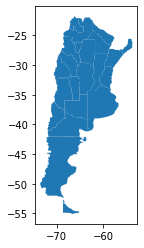

In [28]:
arg_map.plot();

Looks good

### Population fetching and clean up
For population distribution, we use Indec's census carried on in 2011. Data shouldn't have changed a lot since then. Excell downloaded and converted to csv from here https://sitioanterior.indec.gob.ar/nivel4_default.asp?id_tema_1=2&id_tema_2=18&id_tema_3=77 In order to be able to directly download files from within this notebook, I converted the xls to a csv and uploaded it to my Github repo (referenced at the end of this notebook)

In [29]:
urlretrieve('https://raw.githubusercontent.com/SimonAulet/renewable_energies/main/alternative-energies-argentina_files/population_distribution.csv', data_dir+'/population_distribution.csv')

('./alternative-energies-argentina_files/population_distribution.csv',
 <http.client.HTTPMessage at 0x7fbe93cb4070>)

In [30]:
population_distribution_raw_df = pd.read_csv(data_dir+'/population_distribution.csv')

In [31]:
population_distribution_raw_df.head(12)

,"Población por sexo e índice de masculinidad, superficie censada y densidad, según provincia. Total del país. Año 2010",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Provincia,Población,NaN,NaN,NaN,NaN,Superficie censada,Densidad
2,NaN,Total,Sexo,NaN,NaN,Índice de masculinidad (1),NaN,NaN
3,NaN,NaN,Varones,Mujeres,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,Km2,Hab/km2
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Total,40.117.096,19.523.766,20.593.330,NaN,"94,8",3.745.997(2),"10,7(3)"
7,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Ciudad Autónoma de Buenos Aires,2.890.151,1.329.681,1.560.470,NaN,"85,2",200,"14.450,8"
9,Buenos Aires,15.625.084,7.604.581,8.020.503,NaN,"94,8",307.571,"50,8"


This doesn't have a nice layout, it was clearly created with the idea of being watched in Excel. Let's take only rows and columns we need

In [32]:
population_dist = population_distribution_raw_df.loc[8:33].copy()#take main rows
population_dist.rename(columns={'Población por sexo e índice de masculinidad, superficie censada y densidad, según provincia. Total del país. Año 2010': 'province', 'Unnamed: 1': 'population', 'Unnamed: 7': 'density'}, inplace=True)
population_dist = population_dist.loc[:, ['province', 'population']]#remove all but main columns

In [33]:
#Remove dots and commas to avoid conversion errors
population_dist.population = population_dist.population.str.replace('.','', regex=False)

#Set numeric values to numeric types
population_dist.population = pd.to_numeric(population_dist.population)

In [34]:
#Remove repetitive and unnused rows
population_dist.loc[9, 'population'] += population_dist.population[8]
population_dist.drop(10, inplace=True)
population_dist.drop(11, inplace=True)
population_dist.drop(8, inplace=True)

In [35]:
population_dist.province = population_dist.province.str.upper()

In [36]:
population_dist.set_index('province', inplace=True)

In [37]:
population_dist.rename(index={'CÓRDOBA': 'CORDOBA', 'NEUQUÉN': 'NEUQUEN', 'TUCUMÁN': 'TUCUMAN', 'ENTRE RÍOS': 'ENTRE RIOS', 'RÍO NEGRO': 'RIO NEGRO', 'TIERRA DEL FUEGO, ANTÁRTIDA E ISLAS DEL ATLÁNTICO SUR (4)': 'TIERRA DEL FUEGO'}, inplace=True)#Remove accents and match 'Tierra del Fuego'

In [38]:
population_dist.index.isin(arg_map.index)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

Now that every item in population_dist's index is contained in arg_map's index, we can safely merge the first series into it

In [39]:
arg_map = arg_map.join(population_dist)

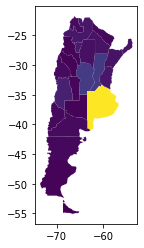

In [40]:
arg_map.plot('population');

## Exploratory Analysis and Visualization

### General view
As a first step, we can have a look at the general renewable power in Argentina, its sources, and their change through the last years. The data spans exactly 10 years

Let's begin by importing`matplotlib.pyplot` and `seaborn`.

In [41]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (9, 5)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

Following is a graph showing available power from all sources of renewables energies in our range of study

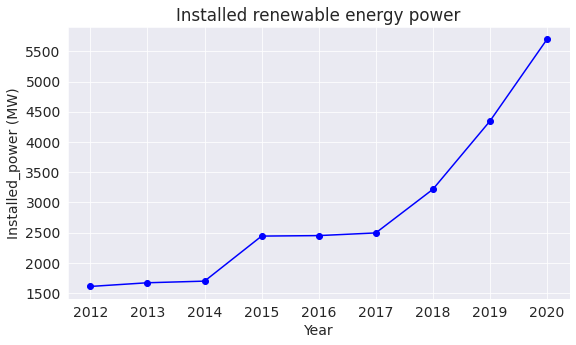

In [42]:
installed_power_df = energies_df[energies_df.indicator == 'Installed_power']
installed_power_total = installed_power_df[installed_power_df.date.dt.month == 12]#we take only the last month, assuming no power source was destroyed to avoid adding months
installed_power_total = installed_power_total.groupby(energies_df.date.dt.year).sum()
plt.title('Installed renewable energy power')
plt.xlabel('Year'); plt.ylabel('Installed_power (MW)')
plt.plot(installed_power_total, 'b-o');

The 2018 and 2019 periods had a considerable development compared to the early years. Now we will see how every source has grown separately through the same time lapse

In [43]:
production_by_source_total = pd.pivot_table(data = installed_power_df,
               index=installed_power_df.date.dt.year,
               columns='energy_source',
               aggfunc='sum')
production_by_source_total.columns = production_by_source_total.columns.droplevel()
production_by_source_total.columns = ['biogas', 'nuclear', 'small_hydro', 'solar', 'wind']
production_by_source_total

,biogas,nuclear,small_hydro,solar,wind
date,,,,,
2012,75.300,12060.0,5656.98,49.40,1194.30
2013,199.200,12105.0,5690.68,94.40,1571.80
2014,199.200,12120.0,5699.08,98.40,2223.00
2015,199.200,20315.0,5716.08,98.40,2248.20
2016,199.200,21060.0,5716.08,98.40,2328.20
2017,221.535,21060.0,5762.98,98.40,2375.50
2018,262.980,21060.0,5863.28,434.29,4731.75
2019,426.380,21060.0,5975.28,4221.11,13912.50
2020,551.100,21060.0,6066.48,6684.56,26073.63


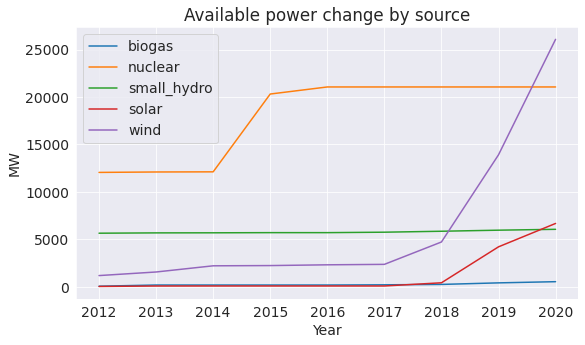

In [44]:
plt.plot(production_by_source_total.biogas)
plt.plot(production_by_source_total.nuclear)
plt.plot(production_by_source_total.small_hydro)
plt.plot(production_by_source_total.solar)
plt.plot(production_by_source_total.wind)
plt.legend(['biogas', 'nuclear', 'small_hydro', 'solar', 'wind'])
plt.xlabel('Year')
plt.ylabel('MW')
plt.title('Available power change by source');

The most interesting sources are wind and solar. Nuclear has a single jump, probably a consequence of nuclear plant construction.
Up next we'll see available power from last year by province (available power is not energy that has been generated but the capacity of the province for generating it)

### Spatial distribution of renewables energies in Argentina
We now focus on which provinces have the most available power in the country. For that, we check the total amount of MW available in 2020 for each province

In [45]:
available_power_2020_df = installed_power_df[installed_power_df.date.dt.year == 2020]
available_power_2020_df = available_power_2020_df[available_power_2020_df.date.dt.month == 12]

In [46]:
aggregated_power_2020_df = available_power_2020_df.groupby('province').sum()

In [47]:
arg_map = arg_map.merge(aggregated_power_2020_df, on='province', how='outer')
arg_map.fillna(0, inplace=True)#We safely fill NaN with ceros because NaN means not production registered
arg_map.rename(columns={'value': 'installed_mw'}, inplace=True)

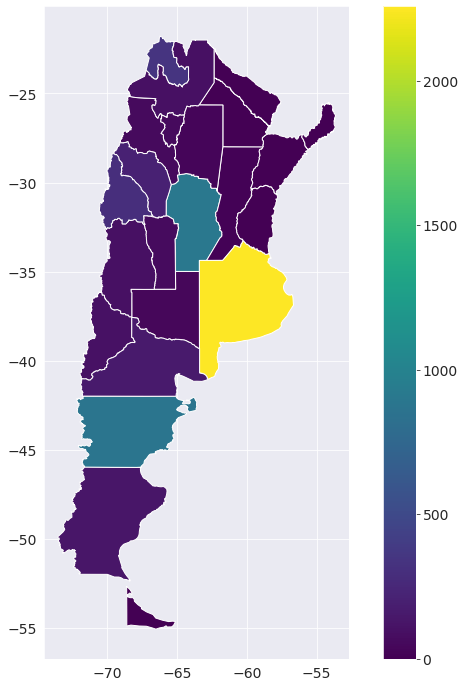

In [48]:
arg_map.plot('installed_mw', cmap='viridis',legend=True, figsize=(12,12));

Roughly production can be divided into 3 groups, with Buenos Aires as, by far, having the highest available power and Córdoba and Chubut next with the rest of the country producing a much smaller amount

## Asking and Answering Questions

At a glance, production is highly centralized. However, natural resources availability and population distribution can greatly affect how the power is installed.
Following, let's see how the balance between production and population distribution is, and where is the highest potential to keep growing the renewable energy production


### Q1: How does population relate with installed renewable energy power province-wise in Argentina?


It would be interesting to see if population and power production go hand to hand or if there is an unbalance. We use previously prepared map to check for distribution

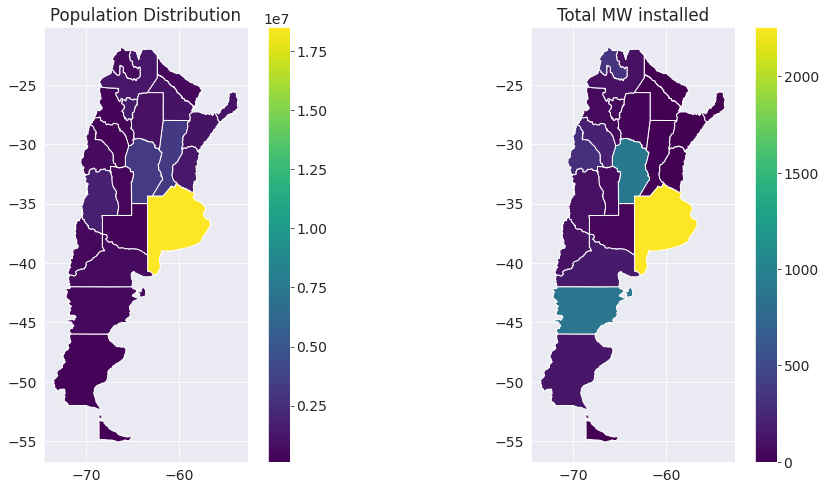

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].set_title('Population Distribution')
arg_map.plot('population', cmap='viridis', legend=True, ax=axes[0])

axes[1].set_title('Total MW installed')
arg_map.plot('installed_mw', cmap='viridis',legend=True, ax=axes[1]);

It makes some sense but there is such a high population concentration in Buenos Aires that maybe a barplot will help more clearly see distribution differences

In [50]:
#We work with percentages
arg_map['population_percentage'] = arg_map['population'] / arg_map['population'].sum() * 100
arg_map['installed_mw_percentage'] = arg_map['installed_mw'] / arg_map['installed_mw'].sum() * 100

In [51]:
arg_map_comparison_df = arg_map.reset_index().melt(id_vars='province', value_vars=['population_percentage', 'installed_mw_percentage'])#Expand for plotting

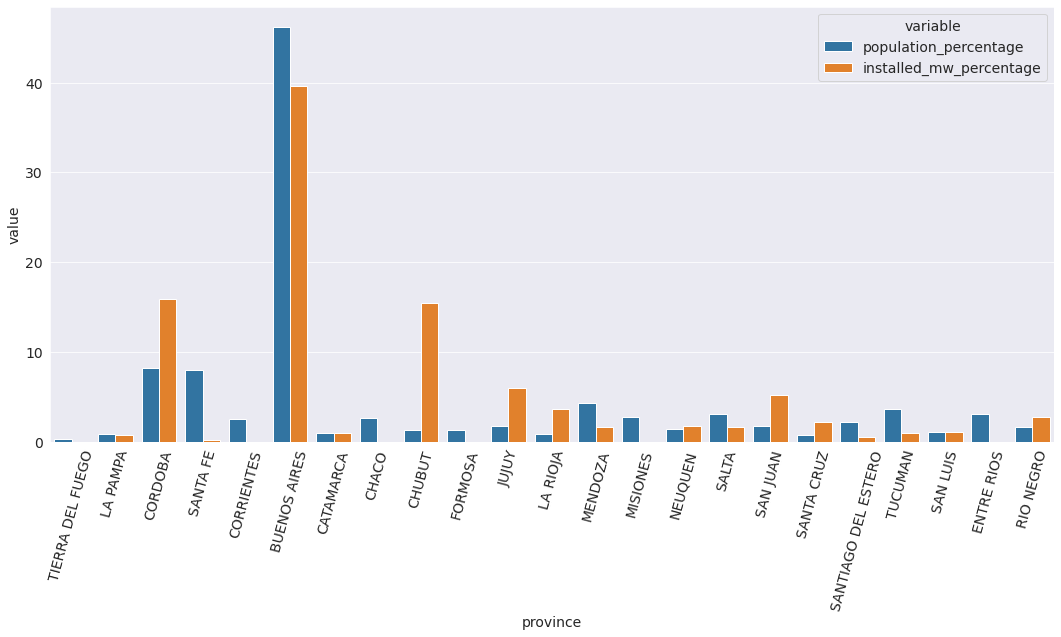

In [52]:
fig, ax = plt.subplots(figsize=(18,8));
plt.xticks(rotation=75)
plt.figsize=(16,16)
sns.barplot(x='province', y='value', hue='variable', data=arg_map_comparison_df, ax=ax);

Chubut has a very high percentage of the power pool and a significantly low population percentage of the Country. That could be because of high renewable availability.

Córdoba, on the other hand, is one of the most populated provinces and is the second-biggest producer. That can be related to the fact that there lays a big portion of the country's industry.

Buenos Aires has the highest population and highest renewable energy production percentage, which makes sense since most of the population and production concentrates there

### Q2: Why do some provinces have such a high percentage of production compared to their population?

Population by itself doesn't represent energy needs in a direct way. We'll always have higher demands on industrial areas. There's also renewable availability which doesn't usually affect how the population distributes over the country (yet) but it does have a significant impact on new renewable energies plants constructions since, in the end, all electricity will go to the interconnected power distributing system.

First, we see which provinces have the most renewable power over their population (always speaking in percentages of the country's total)

In [53]:
(arg_map['installed_mw_percentage'] / arg_map['population_percentage']).sort_values(ascending=False).head(6)

province
CHUBUT        12.174843
LA RIOJA       4.371913
JUJUY          3.530665
SANTA CRUZ     3.238503
SAN JUAN       3.073934
CORDOBA        1.919438
dtype: float64

We focus on Chubut which is where the disparity is most noticeable compared to the rest

In [54]:
installed_power_chubut = installed_power_df[installed_power_df.province == 'CHUBUT']
installed_power_chubut_grouped = installed_power_chubut.pivot('date', 'energy_source', 'value')#We reshape by using a pivot table for a more compressed an clear view
installed_power_chubut_grouped = installed_power_chubut_grouped.groupby(installed_power_chubut_grouped.index.year)[installed_power_chubut_grouped.columns].mean()
installed_power_chubut_grouped

energy_source,Small_hydro,Wind
date,,
2012,46.8,83.700000
2013,46.8,105.533333
2014,46.8,136.700000
2015,46.8,136.700000
2016,46.8,136.700000
2017,46.8,139.308333
2018,46.8,217.116667
2019,46.8,507.050000
2020,46.8,782.983333


We can see that Small Hydro didn't change at all, so it's all about the wind. However, let's graph this table in order to have a more clear intuition on eolic generation change

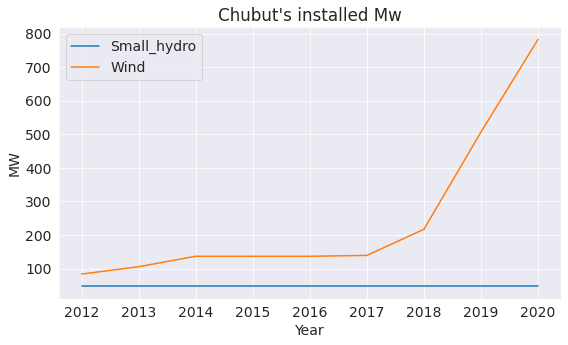

In [55]:
plt.plot(installed_power_chubut_grouped['Small_hydro'])
plt.plot(installed_power_chubut_grouped['Wind']);
plt.legend(['Small_hydro', 'Wind'])
plt.xlabel('Year')
plt.ylabel('MW')
plt.title('Chubut\'s installed Mw');

Apparently, the 2017-2020 period was a good time for wind energy generation parks development since their power got more than five times its original capacity.

It would be interesting to see wind potential in the whole country as a way to justify such growth

### Q3: How does wind speed distribute among Argentina? Is it being well used?

First, we create a dataframe for available wind power in Argentina (2020)

In [56]:
#Lets reshape our original df for clearer view
available_power_2020_df = available_power_2020_df.pivot('province', 'energy_source', 'value')

#Create rows with 0 as data for provinces without renewable energy production using arg_map's structure
missing_values = pd.DataFrame(data=0, index=arg_map.index[~arg_map.index.isin(available_power_2020_df.index)], columns=available_power_2020_df.columns)
available_power_2020_df = available_power_2020_df.append(missing_values)

available_power_2020_df.fillna(0, inplace=True)#Can safely replace NaNs with ceros because pivoting created NaN where cero production was registered
available_power_2020_df

energy_source,Biogas,Nuclear,Small_hydro,Solar,Wind
province,,,,,
BUENOS AIRES,25.300,1107.0,0.00,0.00,1124.510
CATAMARCA,0.000,0.0,0.00,55.50,0.000
CHUBUT,0.000,0.0,46.80,0.00,833.450
CORDOBA,10.160,648.0,116.00,0.00,127.800
JUJUY,0.000,0.0,37.60,300.00,0.000
LA PAMPA,0.000,0.0,0.00,0.00,39.600
LA RIOJA,0.000,0.0,0.00,57.00,150.150
MENDOZA,0.000,0.0,85.46,6.15,0.000
NEUQUEN,0.000,0.0,0.00,0.00,100.485


Now we merge that dataframe in our map

In [57]:
arg_map = arg_map.join(available_power_2020_df.Wind).rename(columns={'Wind': 'wind_available'})

We download a pdf file from https://globalwindatlas.info/area/Argentina and we convert it to jpg to simply watch as an image since only a general view is needed.
The image renders "Mean power density" at 100 mts, which according to Global Wind Atlas, is a measurement of the wind resource. I assume that it will give us a more sophisticated way of interpreting wind's real potential according to their algorithms rather than taking the mean of the raw wind speed from all year. I uploaded the edited image to Github repo so let's download it from there

In [58]:
urlretrieve('https://raw.githubusercontent.com/SimonAulet/renewable_energies/main/alternative-energies-argentina_files/wind_power_density.jpg', data_dir+'/wind_power_density.jpg')

('./alternative-energies-argentina_files/wind_power_density.jpg',
 <http.client.HTTPMessage at 0x7fbe90f1d7c0>)

In [59]:
from PIL import Image#Import Python Image Library for loading and manipulating images
mean_wind_power = Image.open(data_dir+'/wind_power_density.jpg')

Let's compare Mean Wind Density with Wind energy production capacity and Population distribution

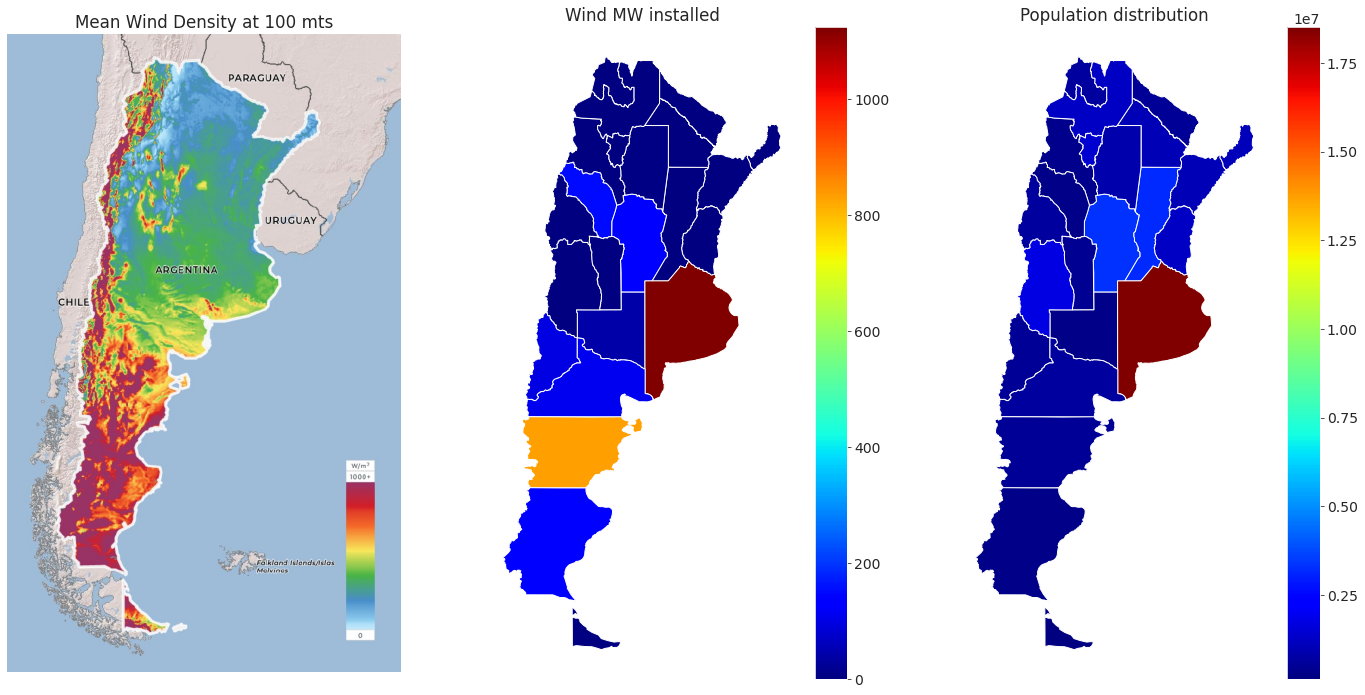

In [60]:
fig, axes = plt.subplots(1, 3, figsize=(24, 12))

axes[0].set_title('Mean Wind Density at 100 mts')
axes[0].grid(False)
axes[0].axis('off')
axes[0].imshow(mean_wind_power);

axes[1].set_title('Wind MW installed')
axes[1].axis('off')
arg_map.plot('wind_available', cmap='jet',legend=True, ax=axes[1]);

axes[2].set_title('Population distribution')
axes[2].axis('off')
arg_map.plot('population', cmap='jet',legend=True, ax=axes[2]);

Colormap used for MW and Population maps isn't the most intuitive given the huge population and production difference in Buenos Aires compared to the rest since data is not normalized, but is the most similar to Mean Wind Density image imported map

Without getting into much detail, it's clear that the mid-lower part of the map (red/orangeish in MW/population map) is being well used, at least proportionally to the whole available power. That's Chubut. Also, Buenos Aires, which has the highest power availability, is the highest populated area.

Apparently, the installation of the wind generation centers is determined both from population presence and raw resources available. Considering the extremely high resource available in mid-low part of the country and the fact that electricity is relatively cheap to transport, it makes sense to see more large-sized eolic parks at center and south of the country in the future

### Q4: How about Solar irradiance? does solar generation distribute in a more population or resource availability biased way?

As before, we start by adding a column to arg_map with 2020's production of our source of interest; in this case, solar

In [61]:
arg_map = arg_map.join(available_power_2020_df.Solar).rename(columns={'Solar':'solar_available'})
arg_map.sample(6)

,geometry,population,installed_mw,population_percentage,installed_mw_percentage,wind_available,solar_available
province,,,,,,,
SAN JUAN,"MULTIPOLYGON (((-70.43129 -31.12824, -70.45532...",681055,297.310,1.697668,5.218519,0.0,199.11
LA PAMPA,"MULTIPOLYGON (((-63.39111 -39.05758, -63.39111...",318951,39.600,0.795050,0.695077,39.6,0.00
JUJUY,"MULTIPOLYGON (((-64.33717 -24.42421, -64.27825...",673307,337.600,1.678354,5.925707,0.0,300.00
CHACO,"MULTIPOLYGON (((-61.71021 -25.71348, -61.71021...",1055259,0.000,2.630447,0.000000,0.0,0.00
SANTA FE,"MULTIPOLYGON (((-61.72119 -27.98955, -61.72394...",3194537,9.815,7.963032,0.172277,0.0,0.00
SANTIAGO DEL ESTERO,"MULTIPOLYGON (((-61.71236 -25.71393, -61.71227...",874006,27.500,2.178637,0.482692,8.0,0.00


We download an image for a general view, this time from Global Solar Atlas: https://globalsolaratlas.info/download/argentina.
Again, we use their measurements of solar potential instead of using direct solar irradiation.
For some reason, their information only reaches south until parallel 42°, so we will limit our focus to middle and northern Argentina. This image is also in my repo (referenced at the end of this notebook)

In [62]:
urlretrieve('https://raw.githubusercontent.com/SimonAulet/renewable_energies/main/alternative-energies-argentina_files/solar_power_potencial.png', data_dir+'/solar_power_potencial.png')

('./alternative-energies-argentina_files/solar_power_potencial.png',
 <http.client.HTTPMessage at 0x7fbe90616820>)

In [63]:
solar_power_potencial = Image.open(data_dir+'/solar_power_potencial.png')

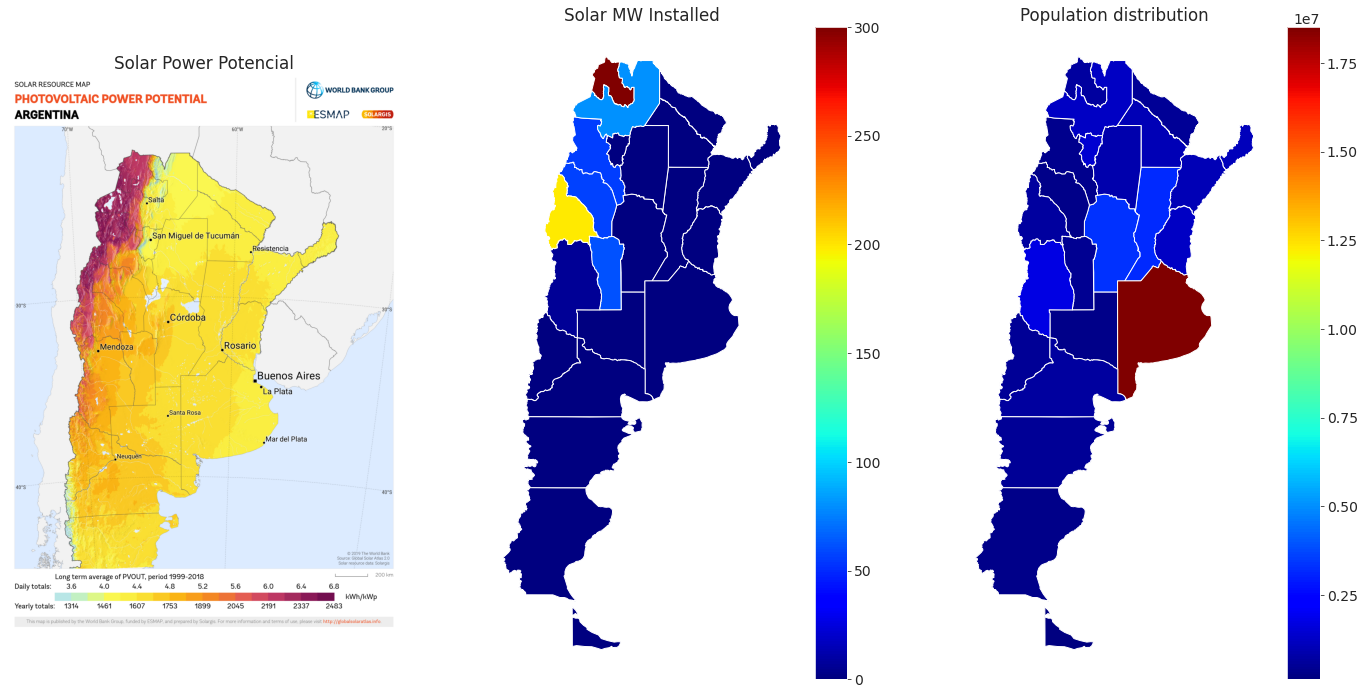

In [64]:
fig, axes = plt.subplots(1, 3, figsize=(24, 12))

axes[0].set_title('Solar Power Potencial')
axes[0].grid(False)
axes[0].axis('off')
axes[0].imshow(solar_power_potencial);

axes[1].set_title('Solar MW Installed')
axes[1].axis('off')
arg_map.plot('solar_available', cmap='jet',legend=True, ax=axes[1]);

axes[2].set_title('Population distribution')
axes[2].axis('off')
arg_map.plot('population', cmap='jet',legend=True, ax=axes[2]);

In this case, solar plants locations are heavily influenced by solar power potential, more than population distribution.
This only measures medium to high scale solar energy production.

It makes sense that, since solar panels are way easier to install in homes than wind (not to mention nuclear or hydro), we could, in the future, have more decentralized production which should be directly related to population distribution rather than solar power potential. This is hard to quantify

### Q5: How is available power of different sources used?

While availability usually means the highest possible output, there is a real, cumulative value of energy that has actually been produced in each plant at each. This might change significantly between different types of resources. A solar power plant can deliver different power max power outputs along the day depending on sun position, and also every day has different sun available hours, depending on the time of year, so we should expect to see a much lower number for generation vs installed power. Wind changes with wind speed which also varies day by day and season by season.
Because of this, it makes no sense to measure efficiency between different resources. We could, however, see how efficiency changes over time for different resources

We use the following formula for measuring what we will call practical efficiency:
$$\text{practical efficiency} = \frac{MWh_{gen}}{MW_{max} \cdot T_{month}}$$
Where:
- $MWh_{gen}$ is the Megawatts/hour generated for that month
- $MW_{max}$ is resource's Mw max capacity
- $T_{month}$ is the amount of hours of the month

The reason for multiplying available power by the number of hours in a month is that every row of generated energy represents one month of accumulated energy generation measured in Megawatts/hour, while every row of available power represents available power at any given time. More to clarify Mw/h and Mw here: https://www.nj.gov/emp/energy/faq.html#2


First, we create a dataframe of generated energy totals with a column of monthly totals for each resource and a similar one for installed power. Since we are not observing by province, we can group by date, splitting only by resource

In [65]:
#create a dataframe for generated an one for available energy
generated_energy_totals_df = energies_df[energies_df.indicator == 'Generated_energy']
installed_power_totals_df = energies_df[energies_df.indicator == 'Installed_power']

We begin by creating a dataframe for grouped totals adding all resources and provinces for each date. Then we add the columns for each resource

In [66]:
generated_energy_grouped_df = generated_energy_totals_df.groupby('date')['value'].sum()
generated_energy_grouped_df = generated_energy_grouped_df.to_frame().reset_index()
generated_energy_grouped_df.rename(columns={'value': 'Total'}, inplace = True)

installed_power_grouped_df = installed_power_totals_df.groupby('date')['value'].sum()
installed_power_grouped_df = installed_power_grouped_df.to_frame().reset_index()
installed_power_grouped_df.rename(columns={'value': 'Total'}, inplace = True)

In [67]:
energies_df.energy_source.unique()

array(['Biogas', 'Biomass', 'Wind', 'Nuclear', 'Small_hydro', 'Solar'],
      dtype=object)

In [68]:
#iterate generated totals dataframe grouping by date for every resource
for source in generated_energy_totals_df.energy_source.unique():
    aux = generated_energy_totals_df[generated_energy_totals_df.energy_source == source].groupby('date')['value'].sum()
    generated_energy_grouped_df = generated_energy_grouped_df.join(aux.rename(source), on='date')

In [69]:
generated_energy_grouped_df.fillna(0, inplace=True)
generated_energy_grouped_df

,date,Total,Biogas,Biomass,Wind,Nuclear,Small_hydro,Solar
0,2011-01-01,644673.206,0.000,6947.531,103.488,523425.400,114196.787,0.000
1,2011-02-01,663297.175,0.000,5995.998,624.601,533123.791,123552.250,0.535
2,2011-03-01,585184.358,0.000,6550.613,727.301,435932.579,141901.945,71.920
3,2011-04-01,477653.630,0.000,6061.267,697.433,342775.862,127942.835,176.233
4,2011-05-01,564097.952,0.000,7542.612,852.787,468287.839,87254.760,159.954
...,...,...,...,...,...,...,...,...
115,2020-08-01,2071420.908,26282.661,50712.155,930126.268,891200.744,86413.019,86686.061
116,2020-09-01,2048381.506,24840.320,52698.064,851903.655,880142.579,113385.346,125411.542
117,2020-10-01,1963557.738,26028.643,50136.050,910151.558,690814.556,135131.945,151294.986
118,2020-11-01,1945676.962,24590.493,53249.299,866446.709,678241.220,128629.255,194519.986


In [70]:
#### iterate installed totals dataframe grouping by date for every resource
for source in installed_power_totals_df.energy_source.unique():
    aux = installed_power_totals_df[installed_power_totals_df.energy_source == source].groupby('date')['value'].sum()#temporary series to hold the data
    installed_power_grouped_df = installed_power_grouped_df.join(aux.rename(source), on='date')

In [71]:
installed_power_grouped_df.fillna(0, inplace=True)
installed_power_grouped_df

,date,Total,Biogas,Wind,Nuclear,Small_hydro,Solar
0,2012-01-01,1561.690,0.000,86.050,1005.0,469.44,1.20
1,2012-02-01,1561.390,0.000,86.050,1005.0,469.14,1.20
2,2012-03-01,1561.390,0.000,86.050,1005.0,469.14,1.20
3,2012-04-01,1561.390,0.000,86.050,1005.0,469.14,1.20
4,2012-05-01,1566.490,5.100,86.050,1005.0,469.14,1.20
...,...,...,...,...,...,...,...
103,2020-08-01,4961.625,45.675,2196.010,1755.0,505.98,458.96
104,2020-09-01,5450.180,47.775,2382.465,1755.0,505.98,758.96
105,2020-10-01,5491.210,47.775,2419.895,1755.0,509.58,758.96
106,2020-11-01,5697.210,50.575,2623.095,1755.0,509.58,758.96


In [72]:
installed_power_grouped_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         108 non-null    datetime64[ns]
 1   Total        108 non-null    float64       
 2   Biogas       108 non-null    float64       
 3   Wind         108 non-null    float64       
 4   Nuclear      108 non-null    float64       
 5   Small_hydro  108 non-null    float64       
 6   Solar        108 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 6.0 KB


In [73]:
generated_energy_grouped_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         120 non-null    datetime64[ns]
 1   Total        120 non-null    float64       
 2   Biogas       120 non-null    float64       
 3   Biomass      120 non-null    float64       
 4   Wind         120 non-null    float64       
 5   Nuclear      120 non-null    float64       
 6   Small_hydro  120 non-null    float64       
 7   Solar        120 non-null    float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 7.6 KB


Seems like the two dataframes have different lengths. Let's see, by index, which values of `generated_energy_grouped_df` are not in `available_power_grouped`

In [74]:
generated_energy_grouped_df[~generated_energy_grouped_df.date.isin(installed_power_grouped_df.date)]

,date,Total,Biogas,Biomass,Wind,Nuclear,Small_hydro,Solar
0,2011-01-01,644673.206,0.0,6947.531,103.488,523425.400,114196.787,0.000
1,2011-02-01,663297.175,0.0,5995.998,624.601,533123.791,123552.250,0.535
2,2011-03-01,585184.358,0.0,6550.613,727.301,435932.579,141901.945,71.920
3,2011-04-01,477653.630,0.0,6061.267,697.433,342775.862,127942.835,176.233
4,2011-05-01,564097.952,0.0,7542.612,852.787,468287.839,87254.760,159.954
5,2011-06-01,640241.815,0.0,6556.974,1191.663,569195.769,63151.512,145.897
6,2011-07-01,690399.865,0.0,7243.114,1178.585,621612.782,60233.128,132.256
7,2011-08-01,697406.658,0.0,10761.486,430.360,608500.667,77527.890,186.255
8,2011-09-01,689278.330,0.0,10974.118,1055.963,575208.400,101835.775,204.074
9,2011-10-01,624299.237,0.0,9334.238,1367.130,501624.333,111763.254,210.282


Apparently, the whole of 2011 has no registry of available renewable power but it does of what has been generated. Since the aim here is to compare available vs generated, we drop 2011's data. Also, although biomass generation has been registered, there's no source of its installed power so we drop that column too

In [75]:
generated_energy_grouped_df.drop(generated_energy_grouped_df[generated_energy_grouped_df.date.dt.year == 2011].index, inplace=True)
generated_energy_grouped_df.drop(columns='Biomass', inplace=True)
generated_energy_grouped_df.reset_index(inplace=True)

Let's create a new dataframe for practical efficiency visualization

In [76]:
biogas = generated_energy_grouped_df.Biogas / (installed_power_grouped_df.Biogas * installed_power_grouped_df.date.dt.daysinmonth * 24)
wind = generated_energy_grouped_df.Wind / (installed_power_grouped_df.Wind * installed_power_grouped_df.date.dt.daysinmonth * 24)
nuclear = generated_energy_grouped_df.Nuclear / (installed_power_grouped_df.Nuclear * installed_power_grouped_df.date.dt.daysinmonth * 24)
small_hydro = generated_energy_grouped_df.Small_hydro / (installed_power_grouped_df.Small_hydro * installed_power_grouped_df.date.dt.daysinmonth * 24)
solar = generated_energy_grouped_df.Solar / (installed_power_grouped_df.Solar * installed_power_grouped_df.date.dt.daysinmonth * 24)

efficiency_df = pd.DataFrame(data={'date': installed_power_grouped_df.date, 'wind': wind, 'solar': solar, 'small_hydro': small_hydro, 'biogas': biogas, 'nuclear': nuclear})
efficiency_df.fillna(0, inplace=True)
efficiency_df

,date,wind,solar,small_hydro,biogas,nuclear
0,2012-01-01,0.294458,0.252941,0.401595,0.000000,0.787966
1,2012-02-01,0.378188,0.238057,0.351404,0.000000,0.757692
2,2012-03-01,0.384029,0.201142,0.427489,0.000000,0.696966
3,2012-04-01,0.411112,0.199321,0.365274,0.000000,0.410566
4,2012-05-01,0.457577,0.499243,0.299721,0.201593,0.475672
...,...,...,...,...,...,...
103,2020-08-01,0.569291,0.253864,0.229548,0.773424,0.682536
104,2020-09-01,0.496628,0.229502,0.311237,0.722144,0.696536
105,2020-10-01,0.505527,0.267937,0.356429,0.732281,0.529068
106,2020-11-01,0.458770,0.355970,0.350586,0.675303,0.536753


#### Solar

We begin by exploring solar. In order to see not only the variance of practical efficiency by itself but also how much power was installed, the shadowed blue line represents installed power, and the single gray line practical efficiency

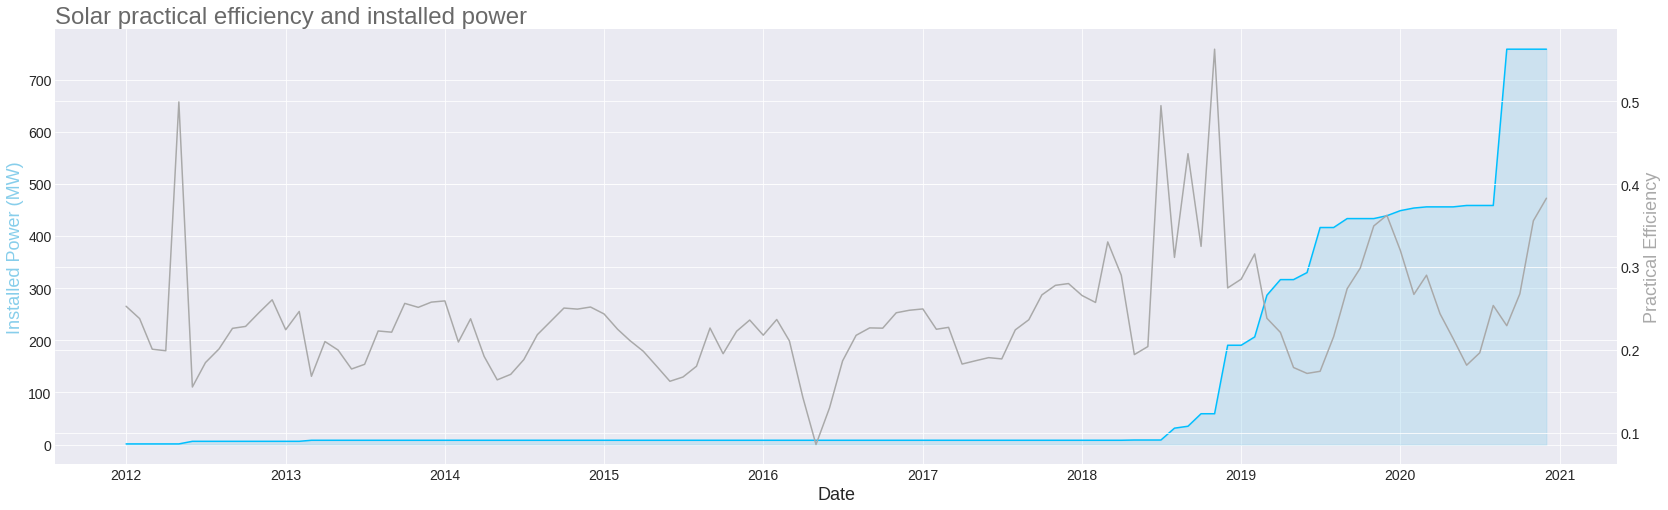

In [77]:
plt.style.use('seaborn-darkgrid')
fig,ax = plt.subplots(figsize=(28,8))

ax.set_title('Solar practical efficiency and installed power', loc='left', fontsize=24, color='dimgrey')
ax.set_xlabel('Date', fontsize=18)

#installed power
ax.set_ylabel('Installed Power (MW)', fontsize=18, color='skyblue')
ax.fill_between(installed_power_grouped_df.date, installed_power_grouped_df.Solar, color='skyblue', alpha=0.3)
ax.plot(installed_power_grouped_df.date, installed_power_grouped_df.Solar, color='deepskyblue')

#practical efficiency
ax2=ax.twinx()
ax2.set_ylabel('Practical Efficiency', fontsize=18, color='darkgrey')
ax2.plot(efficiency_df.date, efficiency_df.solar, color='darkgrey');

As time went on and the available power grew bigger, practical efficiency seems to have grown by a bit in its peaks while apparently maintaining its lower values at the same level.
The peaks at 2018 - 2019 can be because of data noise since they start just when the available power starts growing. Maby because of rounding, since data is collected on a monthly basis

There seems to be an annual cycle, especially before the installed power main increase. Maby a scatter plot can tell us more

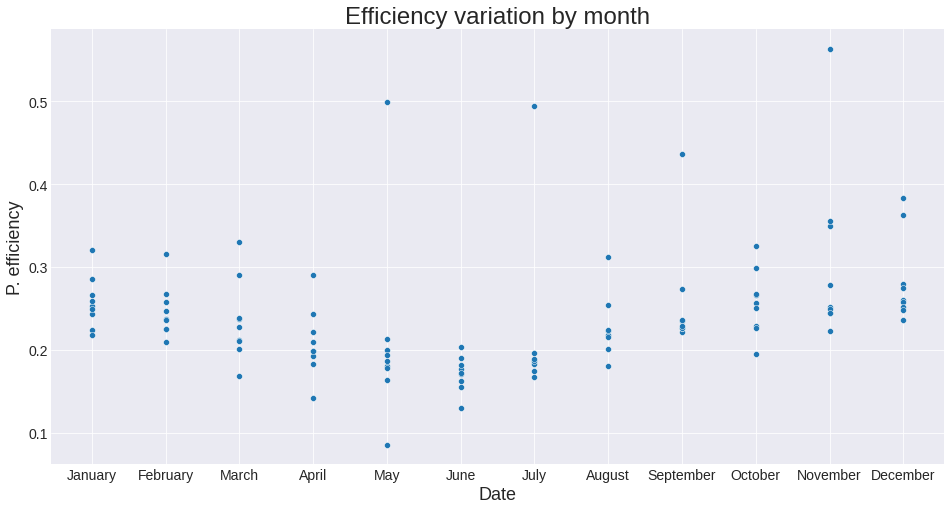

In [78]:
fig, ax = plt.subplots(figsize=(16,8))
ax.set_title('Efficiency variation by month', fontsize=24)
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('P. efficiency', fontsize=18)
sns.scatterplot(ax=ax, x=efficiency_df.date.dt.month_name(), y=efficiency_df.solar);

The lowest efficiency periods are around June which, in Argentina, is when the days have the lowest sun hours (winter). Variation in summer days is more noticeable, probably because of higher impact at solar irradiance thanks to clouds

#### Wind

We begin with the same plot as solar

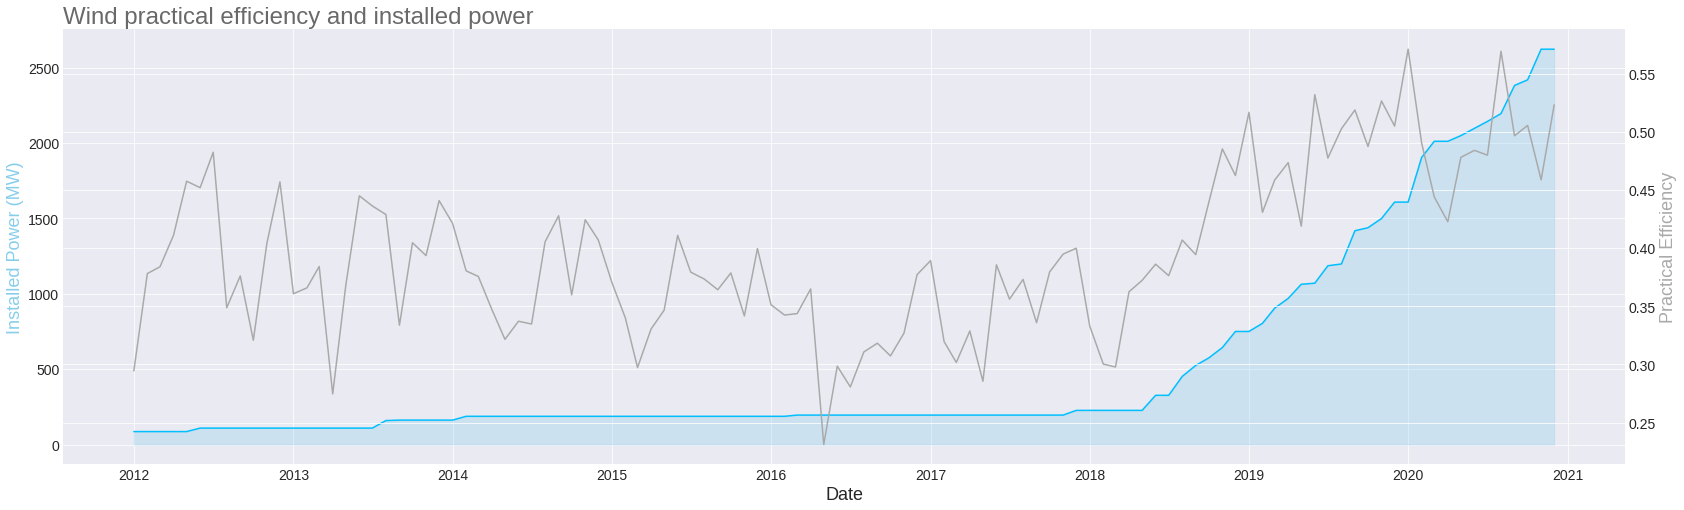

In [79]:
plt.style.use('seaborn-darkgrid')
fig,ax = plt.subplots(figsize=(28,8))

ax.set_title('Wind practical efficiency and installed power', loc='left', fontsize=24, color='dimgrey')
ax.set_xlabel('Date', fontsize=18)

#installed power
ax.set_ylabel('Installed Power (MW)', fontsize=18, color='skyblue')
ax.fill_between(installed_power_grouped_df.date, installed_power_grouped_df.Wind, color='skyblue', alpha=0.3)
ax.plot(installed_power_grouped_df.date, installed_power_grouped_df.Wind, color='deepskyblue')

#practical efficiency
ax2=ax.twinx()
ax2.set_ylabel('Practical Efficiency', fontsize=18, color='darkgrey')
ax2.plot(efficiency_df.date, efficiency_df.wind, color='darkgrey');

In this case, practical efficiency seems to have grown when adding power installations. There doesn't seem to be a correlation between efficiency and month, however, let's see the scatterplot for wind too. In this case, since practical efficiency mean changes when adding installations, we make two plots, one for before 2018 and the other for the total

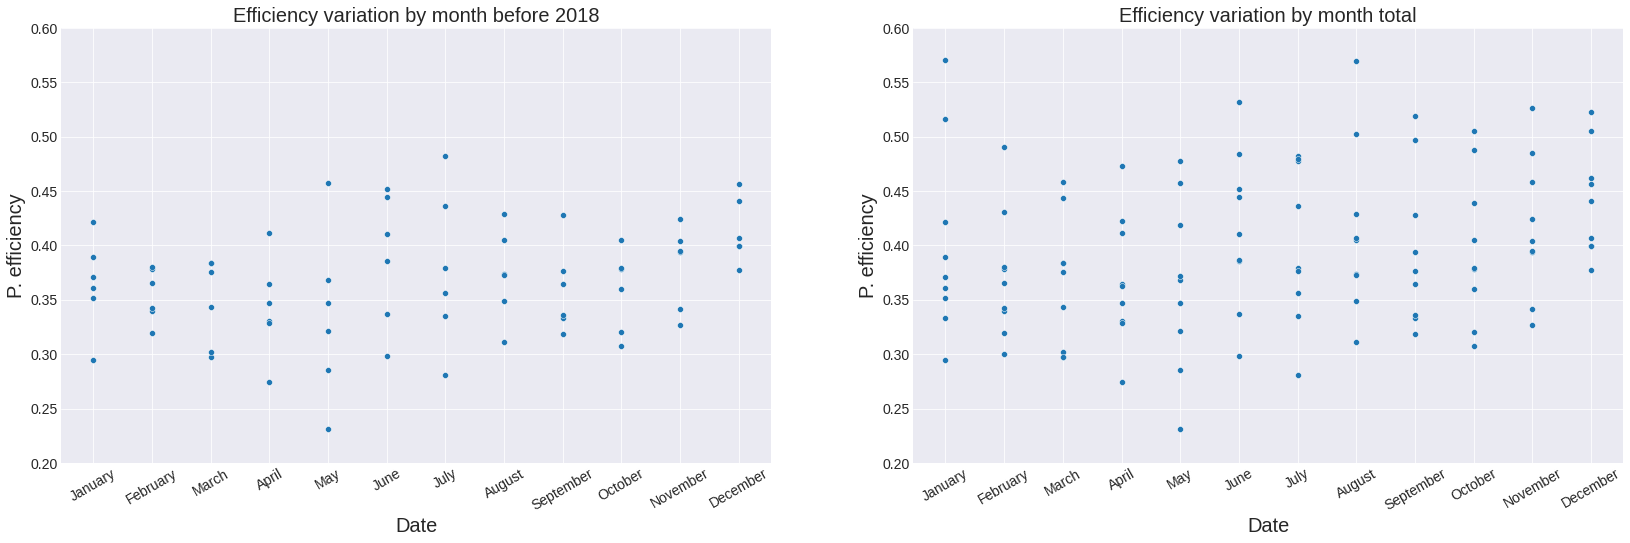

In [80]:
fig, ax = plt.subplots(1, 2, figsize=(28,8))

ax[0].set_title('Efficiency variation by month before 2018', fontsize=20)
ax[0].set_xlabel('Date', fontsize=20)
ax[0].set_ylabel('P. efficiency', fontsize=20)
ax[0].tick_params(axis='x', labelrotation = 30)
ax[0].set_ylim(bottom=0.2, top=0.6)
sns.scatterplot(ax=ax[0], x=efficiency_df[efficiency_df.date.dt.year < 2018].date.dt.month_name(), y=efficiency_df[efficiency_df.date.dt.year < 2018].wind);

ax[1].set_title('Efficiency variation by month total', fontsize=20)
ax[1].set_xlabel('Date', fontsize=20)
ax[1].set_ylabel('P. efficiency', fontsize=20)
ax[1].tick_params(axis='x', labelrotation = 30)
ax[1].set_ylim(bottom=0.2, top=0.6)
sns.scatterplot(ax=ax[1], x=efficiency_df.date.dt.month_name(), y=efficiency_df.wind);

There is no clear sign of a pattern. Deviation seems to have gone up from 2018 but this is only because the mean efficiency has gone up and we are grouping by month

Let's see how much the efficiency changes by measuring all sources standard deviation

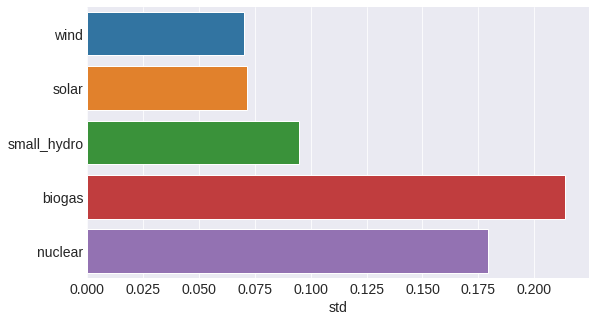

In [81]:
efficiency_std = pd.DataFrame(data=efficiency_df.std(), index=efficiency_df.columns.values, columns=['std'])
efficiency_std.drop('date', inplace=True)
sns.barplot(x='std', y=efficiency_std.index.values, data=efficiency_std);

We can see in this graph that wind and solar energy have similar deviations. Looking back at the solar graph done before, the $y$ axis goes way higher because of some particularly high efficient months (probably data rounding issues)
Between Wind and solar, practical efficiency is similar but, apparently, its change is more predictable with solar than with wind

Finally, let's have a look at all energy source's practical efficiency at once. Since we've done most of the investigation in solar and wind energy, we will not get into much detail now about the other three

**Note** The following cell y basically copy-paste of above's graphs for every plot

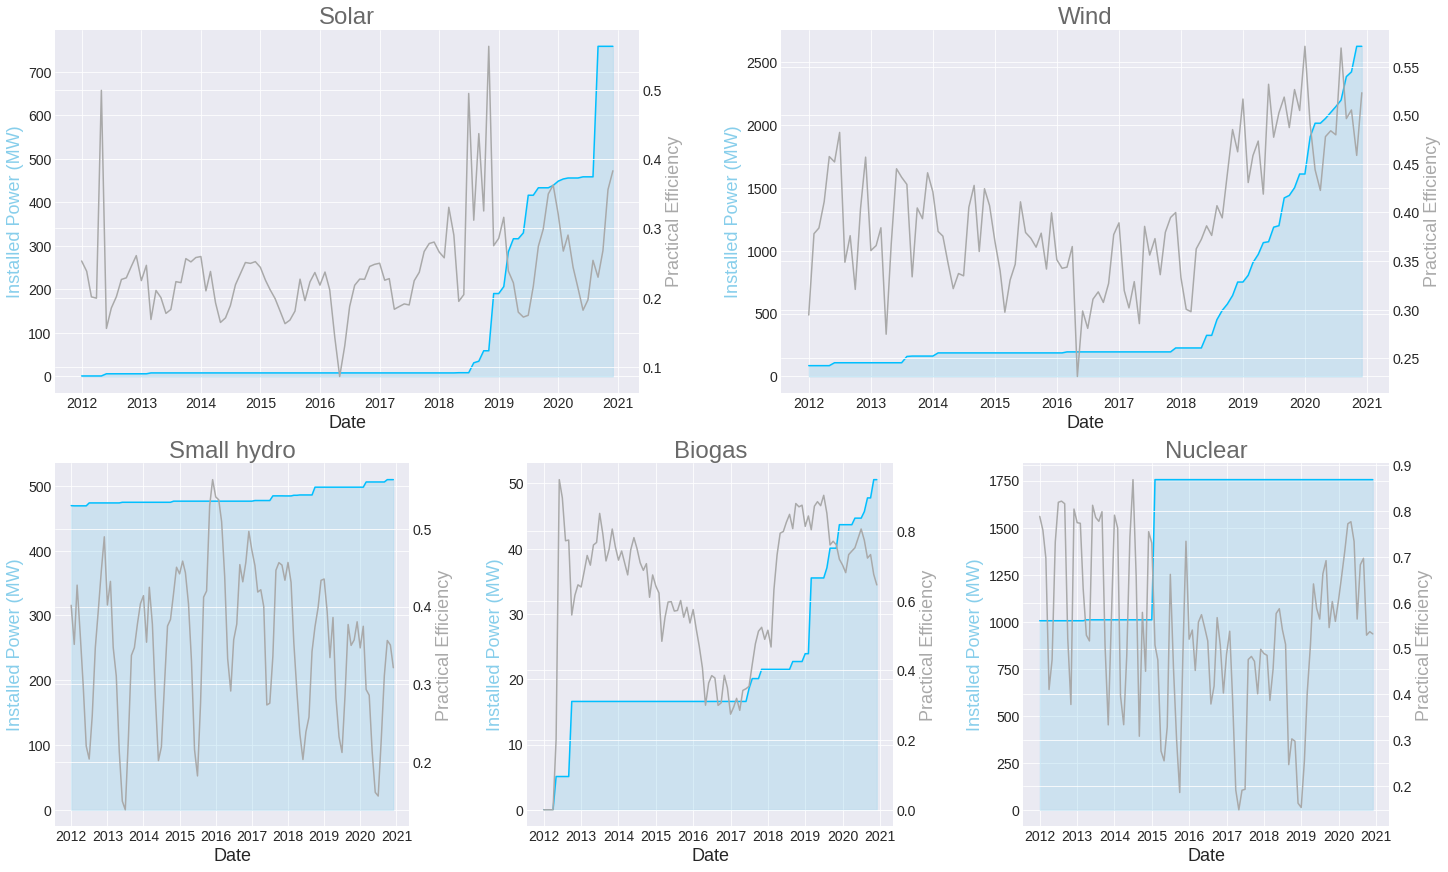

In [82]:
from matplotlib.gridspec import GridSpec #We use GridSpec for not simmetricaly distributed grid plots

fig = plt.figure(constrained_layout=True, figsize=(20, 12))
gs = GridSpec(2, 6, figure=fig)

#Solar
ax1 = fig.add_subplot(gs[0, 0:3])
ax1.set_title('Solar', fontsize=24, color='dimgrey')
ax1.set_xlabel('Date', fontsize=18)
#installed power
ax1.set_ylabel('Installed Power (MW)', fontsize=18, color='skyblue')
ax1.fill_between(installed_power_grouped_df.date, installed_power_grouped_df.Solar, color='skyblue', alpha=0.3)
ax1.plot(installed_power_grouped_df.date, installed_power_grouped_df.Solar, color='deepskyblue')
#practical efficiency
ax12=ax1.twinx()
ax12.set_ylabel('Practical Efficiency', fontsize=18, color='darkgrey')
ax12.plot(efficiency_df.date, efficiency_df.solar, color='darkgrey')

#Wind
ax2 = fig.add_subplot(gs[0, 3:6])
ax2.set_title('Wind', fontsize=24, color='dimgrey')
ax2.set_xlabel('Date', fontsize=18)
#installed power
ax2.set_ylabel('Installed Power (MW)', fontsize=18, color='skyblue')
ax2.fill_between(installed_power_grouped_df.date, installed_power_grouped_df.Wind, color='skyblue', alpha=0.3)
ax2.plot(installed_power_grouped_df.date, installed_power_grouped_df.Wind, color='deepskyblue')
#practical efficiency
ax22=ax2.twinx()
ax22.set_ylabel('Practical Efficiency', fontsize=18, color='darkgrey')
ax22.plot(efficiency_df.date, efficiency_df.wind, color='darkgrey')

#Small Hydro
ax3 = fig.add_subplot(gs[1:, 0:2])
ax3.set_title('Small hydro', fontsize=24, color='dimgrey')
ax3.set_xlabel('Date', fontsize=18)
#installed power
ax3.set_ylabel('Installed Power (MW)', fontsize=18, color='skyblue')
ax3.fill_between(installed_power_grouped_df.date, installed_power_grouped_df.Small_hydro, color='skyblue', alpha=0.3)
ax3.plot(installed_power_grouped_df.date, installed_power_grouped_df.Small_hydro, color='deepskyblue')
#practical efficiency
ax32=ax3.twinx()
ax32.set_ylabel('Practical Efficiency', fontsize=18, color='darkgrey')
ax32.plot(efficiency_df.date, efficiency_df.small_hydro, color='darkgrey')

#Biogas
ax4 = fig.add_subplot(gs[1, 2:4])
ax4.set_title('Biogas', fontsize=24, color='dimgrey')
ax4.set_xlabel('Date', fontsize=18)
#installed power
ax4.set_ylabel('Installed Power (MW)', fontsize=18, color='skyblue')
ax4.fill_between(installed_power_grouped_df.date, installed_power_grouped_df.Biogas, color='skyblue', alpha=0.3)
ax4.plot(installed_power_grouped_df.date, installed_power_grouped_df.Biogas, color='deepskyblue')
#practical efficiency
ax42=ax4.twinx()
ax42.set_ylabel('Practical Efficiency', fontsize=18, color='darkgrey')
ax42.plot(efficiency_df.date, efficiency_df.biogas, color='darkgrey')

#Nuclear
ax5 = fig.add_subplot(gs[1, 4:6])
ax5.set_title('Nuclear', fontsize=24, color='dimgrey')
ax5.set_xlabel('Date', fontsize=18)
#installed power
ax5.set_ylabel('Installed Power (MW)', fontsize=18, color='skyblue')
ax5.fill_between(installed_power_grouped_df.date, installed_power_grouped_df.Nuclear, color='skyblue', alpha=0.3)
ax5.plot(installed_power_grouped_df.date, installed_power_grouped_df.Nuclear, color='deepskyblue')
#practical efficiency
ax52=ax5.twinx()
ax52.set_ylabel('Practical Efficiency', fontsize=18, color='darkgrey')
ax52.plot(efficiency_df.date, efficiency_df.nuclear, color='darkgrey');

Since nuclear doesn't depend on climate conditions, we can assume that its variation is related to operators turning generators on and off.
Small Hydro's variation might be because of water flow in different seasons of the year.
Biogas is mostly produced by a residue of organic matter from urban and agricultural production (https://www.enel.com.ar/Home-Enel/stories/a201802-biomass-grows-in-argentina.html)

## Inferences and Conclusion

While this study's main goal has been to practice abilities learned from Jovian by exploring data and graphing it in a way most suited for what I wanted to see, we can still get some conclusions and information from it:

- Argentina has a huge renewable potential. Large zones of the country are in the max wind and solar potential based on solar and wind Atlas; wind mostly in the south and sun in the north. To understand this we must refer to the downloaded solar and wind potential maps respectively, and consider that the color bar is absolute, for the world, not relative to Argentina.
- While renewable sources are being used, their distribution is not optimal enough. Considering the fact that the whole country is interconnected with high voltage lines, wind and solar parks could develop a lot more
- Despite the inherent waste of energy by inevitable facts (night, clouds, wind slowing down), most energy is being used. Our practical efficiency variable was a variable created to understand this data and is not something that actually reflects the installation's practical or expected potential vs what is being used. However, we saw that the power delivered didn't change that much with time except in the case of wind which went up, so, creating new renewable sources doesn't mean that we will have more waste because of the over-dimension of power plants. Energy is being used.

## References and Future Work

#### Expanding investigation
We only focused on renewables energies but did not see the big picture of how they compete against non-renewable like gas or coal which, sadly, represent the biggest percentage of energy production.
Where that energy is generated and how it can be replaced could be an interesting future work.

#### Sources for further study
In order to see wind and solar potential, solar and wind atlas are good sources:
- https://globalsolaratlas.info/
- https://globalwindatlas.info/

Most official energy data of Argentina can be found here (Spanish):
- https://datos.gob.ar/dataset?groups=ener

#### Data extracted for this notebook
- Main repository with this notebook and all its data https://github.com/SimonAulet/renewable_energies
- Kaggle's main dataset (downloaded with Open Data Sets) https://www.kaggle.com/ccollado7/alternative-energies-argentina
- Argentina's general map https://nicoarzani.carto.com/tables/provincias_argentina/public (in order to download directly from notebook, refer to "Map cleaning up and merging"
- Population distribution according to the census  (Have to enter and download) https://sitioanterior.indec.gob.ar/nivel4_default.asp?id_tema_1=2&id_tema_2=18&id_tema_3=77

Upload notebook to Jovian

In [83]:
import jovian
jovian.commit(project_name='zerotopandas-course-project', filename='zerotopandas-course-project')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[jovian] Updating notebook "simon-aulet/zerotopandas-course-project" on https://jovian.ai/
[jovian] Committed successfully! https://jovian.ai/simon-aulet/zerotopandas-course-project


'https://jovian.ai/simon-aulet/zerotopandas-course-project'